In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow import keras
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)
from tensorflow.keras.layers.experimental import preprocessing

2.7.0
2.7.0


In [2]:
import pandas as pd

def load_data(data_path='data'):
    train_csv_path = os.path.join(data_path, "train.csv")
    test_csv_path = os.path.join(data_path, "test.csv")
    return pd.read_csv(train_csv_path, index_col='Id'), pd.read_csv(test_csv_path, index_col='Id')

train, test = load_data()

/home/marek/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
num_classes = train['Cover_Type'].nunique()
input_shape = (train.shape[1]-1)

In [4]:
train['Cover_Type'].nunique()

7

In [5]:
y_train = train['Cover_Type']

In [6]:
train.drop('Cover_Type', axis=1, inplace=True)

In [7]:
train.shape

(4000000, 54)

In [8]:
test.shape

(1000000, 54)

In [9]:
y_binary = to_categorical(y_train.values-1)

In [10]:
y_binary.shape

(4000000, 7)

In [11]:
input_shape

54

In [12]:
train.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [17]:
train.loc[train.Aspect<0, 'Aspect'] = train.loc[train.Aspect<0, 'Aspect'] + 360.0

In [20]:
train.loc[train.Aspect>360, 'Aspect'] = train.loc[train.Aspect>360.0, 'Aspect'] - 360.0

In [22]:
test.loc[test.Aspect<0, 'Aspect'] = test.loc[test.Aspect<0, 'Aspect'] + 360.0
test.loc[test.Aspect>360, 'Aspect'] = test.loc[test.Aspect>360.0, 'Aspect'] - 360.0

In [27]:
train.loc[train.Hillshade_9am<0, 'Hillshade_9am'] = 0
train.loc[train.Hillshade_9am>255, 'Hillshade_9am'] = 255
train.loc[train.Hillshade_Noon<0, 'Hillshade_Noon'] = 0
train.loc[train.Hillshade_Noon>255, 'Hillshade_Noon'] = 255
train.loc[train.Hillshade_3pm<0, 'Hillshade_3pm'] = 0
train.loc[train.Hillshade_3pm>255, 'Hillshade_3pm'] = 255

test.loc[test.Hillshade_9am<0, 'Hillshade_9am'] = 0
test.loc[test.Hillshade_9am>255, 'Hillshade_9am'] = 255
test.loc[test.Hillshade_Noon<0, 'Hillshade_Noon'] = 0
test.loc[test.Hillshade_Noon>255, 'Hillshade_Noon'] = 255
test.loc[test.Hillshade_3pm<0, 'Hillshade_3pm'] = 0
test.loc[test.Hillshade_3pm>255, 'Hillshade_3pm'] = 255

In [29]:
from sklearn.preprocessing import RobustScaler

In [30]:
transformer = RobustScaler().fit(train)

In [31]:
train = transformer.transform(train)

In [32]:
test = transformer.transform(test)

In [33]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[input_shape]),
    
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(num_classes, activation='softmax'),
])


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               14080     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

In [36]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(min_delta=0.0005, patience=4, restore_best_weights=True)

In [37]:
batch_size = 1024
epochs = 50

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train, 
                    y_binary, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[early_stopping], 
                    validation_split=0.2,
                    workers=8,
                    use_multiprocessing=True,
                   )


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3124/3125 [============================>.] - ETA: 0s - loss: 0.2823 - categorical_accuracy: 0.9025WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc19876dd40> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VER

In [38]:
batch_size = 1024
epochs = 50

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train, 
                    y_binary, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[early_stopping], 
                    validation_split=0.2,
                    workers=8,
                    use_multiprocessing=True,
                   )


Epoch 1/50
3125/3125 [==============================] - 33s 11ms/step - loss: 0.0979 - categorical_accuracy: 0.9569 - val_loss: 0.0975 - val_categorical_accuracy: 0.9565
Epoch 2/50
3125/3125 [==============================] - 38s 12ms/step - loss: 0.0977 - categorical_accuracy: 0.9571 - val_loss: 0.0973 - val_categorical_accuracy: 0.9565
Epoch 3/50
3125/3125 [==============================] - 38s 12ms/step - loss: 0.0971 - categorical_accuracy: 0.9571 - val_loss: 0.0969 - val_categorical_accuracy: 0.9567
Epoch 4/50
3125/3125 [==============================] - 37s 12ms/step - loss: 0.0970 - categorical_accuracy: 0.9572 - val_loss: 0.0965 - val_categorical_accuracy: 0.9568
Epoch 5/50
3125/3125 [==============================] - 61s 19ms/step - loss: 0.0967 - categorical_accuracy: 0.9573 - val_loss: 0.0972 - val_categorical_accuracy: 0.9563
Epoch 6/50
3125/3125 [==============================] - 39s 12ms/step - loss: 0.0963 - categorical_accuracy: 0.9574 - val_loss: 0.0962 - val_categoric

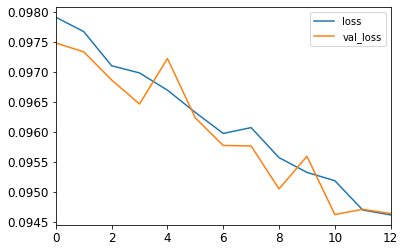

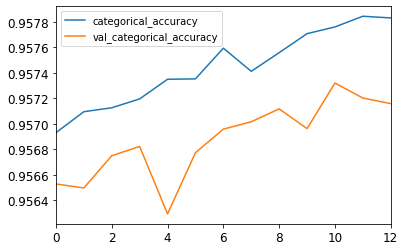

In [39]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()
# plt.ylim([0.985, 1.0])

In [47]:
early_stopping = EarlyStopping(min_delta=0.0005, patience=10, restore_best_weights=True)

In [48]:
batch_size = 1024
epochs = 50

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train, 
                    y_binary, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[early_stopping], 
                    validation_split=0.2,
                    workers=8,
                    use_multiprocessing=True,
                   )


Epoch 1/50
3125/3125 [==============================] - 30s 9ms/step - loss: 0.0953 - categorical_accuracy: 0.9577 - val_loss: 0.0947 - val_categorical_accuracy: 0.9574
Epoch 2/50
3125/3125 [==============================] - 31s 10ms/step - loss: 0.0951 - categorical_accuracy: 0.9577 - val_loss: 0.0946 - val_categorical_accuracy: 0.9571
Epoch 3/50
3125/3125 [==============================] - 31s 10ms/step - loss: 0.0950 - categorical_accuracy: 0.9577 - val_loss: 0.0945 - val_categorical_accuracy: 0.9572
Epoch 4/50
3125/3125 [==============================] - 31s 10ms/step - loss: 0.0946 - categorical_accuracy: 0.9579 - val_loss: 0.0947 - val_categorical_accuracy: 0.9572
Epoch 5/50
3125/3125 [==============================] - 32s 10ms/step - loss: 0.0943 - categorical_accuracy: 0.9580 - val_loss: 0.0943 - val_categorical_accuracy: 0.9571
Epoch 6/50
3125/3125 [==============================] - 31s 10ms/step - loss: 0.0942 - categorical_accuracy: 0.9580 - val_loss: 0.0948 - val_categorica

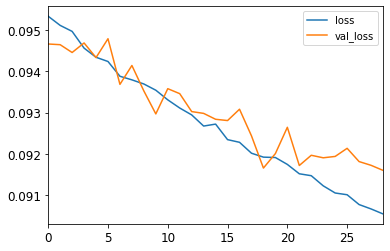

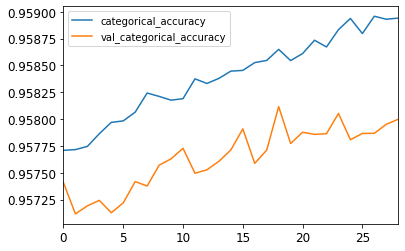

In [49]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()
# plt.ylim([0.985, 1.0])

In [50]:
predictions = model.predict(test)

In [51]:
predictions_cat = predictions.argmax(axis=1)+1

In [52]:
predictions_cat.shape

(1000000,)

In [53]:
predictions[0]

array([3.7729782e-07, 9.9998355e-01, 1.5884081e-05, 7.8479147e-08,
       2.7216553e-08, 9.8754214e-08, 9.9533652e-09], dtype=float32)

In [54]:
predictions_cat[0]

2

In [55]:
sub = pd.DataFrame({'Id': list(range(4000000,5000000)), 'Cover_Type': predictions_cat})
sub.shape

(1000000, 2)

In [56]:
sub.to_csv("data/submission_08_fixed_features2.csv", index=False)

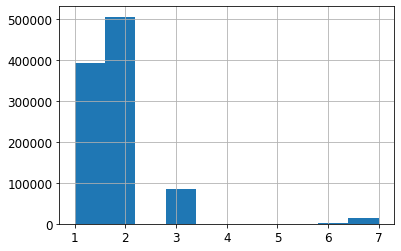

In [30]:
sub['Cover_Type'].hist()